# GHG Emission Multivariate Modeling with CO2 and Socioeconomic Data: *Random Forest*

GE Vernova (Team 2): Dan Dryer, Joanna Rashid, Nhu Y Pham

In [57]:
#load packages
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

### setup

In [58]:
local_path=r'C:/Users/ddrye/OneDrive/Documents/OMSA_Program/OMSA 2023\Summer2023/Practicum/off_git/data/'
df=pd.read_csv(local_path+r"2014_2020_all_tract.csv")
df=df.query('socioeconomic >= 0 & household_comp >= 0 & minority_status >= 0 & housing_type >= 0 and overall_svi >=0')
df=df.query('year==2018')
df['labels']=pd.cut(df['avg_co2'], 3, labels=['low','medium','high'])
df['labels'].value_counts()
df=df[['total_population', 'housing_units', 'num_households', 'unemployment',
       'socioeconomic', 'household_comp', 'minority_status', 'housing_type',
       'overall_svi', 'labels']]

In [59]:
# Split the data into features (X) and target (y)
X = df.drop('labels', axis=1)
y = df['labels']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Optimize model parameters

In [43]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

"# number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# number of features at every split\nmax_features = ['auto', 'sqrt']\n\n# max depth\nmax_depth = [int(x) for x in np.linspace(100, 500, num = 11)]\nmax_depth.append(None)\n# create random grid\nrandom_grid = {\n 'n_estimators': n_estimators,\n 'max_features': max_features,\n 'max_depth': max_depth\n }\n# Random search of parameters\nrfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)\n# Fit the model\nrfc_random.fit(X_train, y_train)\n# print results\nprint(rfc_random.best_params_)"

### Re-run with optimal parameters

In [60]:
rfc = RandomForestClassifier(n_estimators=1600, max_depth=340, max_features='sqrt')
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)

### Check performance

=== Confusion Matrix ===
[[ 3864     1  4164]
 [   88    27  1011]
 [ 1914    11 10506]]


=== Classification Report ===
              precision    recall  f1-score   support

        high       0.66      0.48      0.56      8029
         low       0.69      0.02      0.05      1126
      medium       0.67      0.85      0.75     12431

    accuracy                           0.67     21586
   macro avg       0.67      0.45      0.45     21586
weighted avg       0.67      0.67      0.64     21586





<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

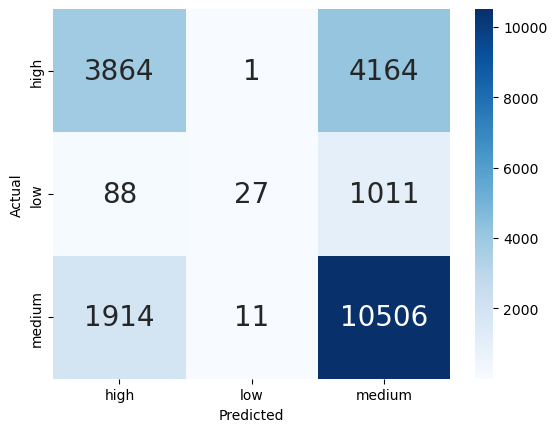

In [61]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')

vars=['high','low','medium']
confusion_mat=confusion_matrix(y_test, rfc_predict)
df_cm = pd.DataFrame(confusion_mat, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20}, fmt='g')# font size
#sns.set(font_scale=1.4)#for label size
#sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

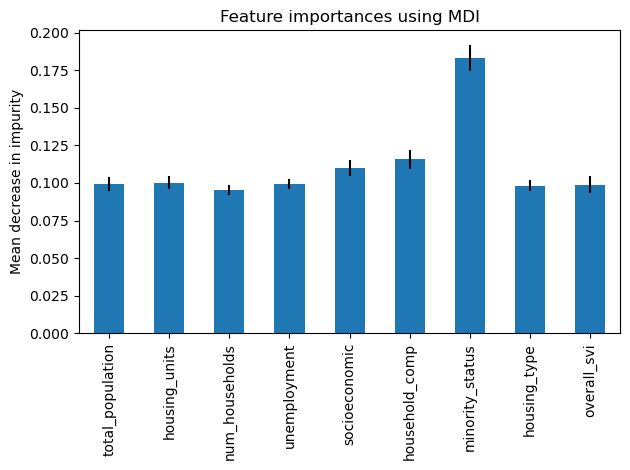

In [62]:
feature_names=X_train.columns
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [63]:
result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)


forest_importances = pd.Series(result.importances_mean, index=feature_names)

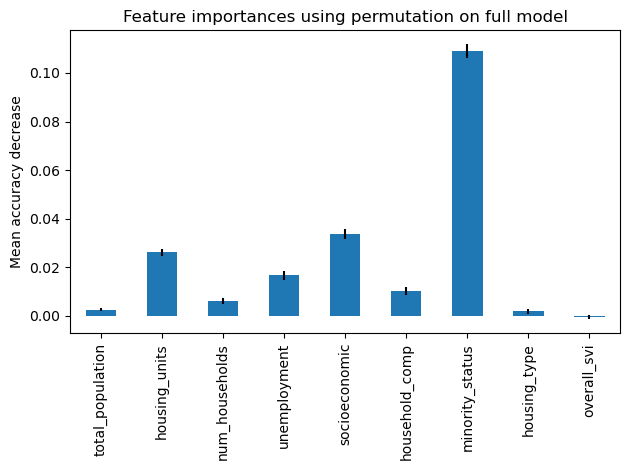

In [64]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()